## 자연어 처리 딥러닝
# Seq2seq : 영어-불어 번역기

- http://keras.io/examples/lstm_seq2seq/
- 데이타 : http://www.manythings.org/anki/fra-eng.zip

<img src='https://www.d2l.ai/_images/seq2seq.svg' />
(출처: https://www.d2l.ai/chapter_recurrent-neural-networks/seq2seq.html)

- Encoder 와 Decoder 두 개의 모델을 만든고 연결한다.
- Encoder 는 최종 상태값을 Decoder 에게 넘긴다. (Decoder 의 초기 상태입력값이 된다.)
- Decoder 의 목표값은 불어 문장에서 한 단어씩 밀린 문장이다. (최종 출력 문장과 비교하여 손실값 계산)
- Seq2seq 는 번역과 같이 쌍으로 된 문장들에 적용한다. => 문장 생성용으로 챗봇 또는 Q/A 등에 사용된다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls /content/drive/MyDrive/*.txt

/content/drive/MyDrive/dataset.txt  /content/drive/MyDrive/지능설계.txt
/content/drive/MyDrive/fra.txt


In [5]:
with open('/content/drive/MyDrive/fra.txt', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [6]:
display(len(lines), lines[:10], lines[-3:])

149862

['Go.\tVa !',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!',
 'Wow!\tÇa alors\u202f!',
 'Fire!\tAu feu !',
 "Help!\tÀ l'aide\u202f!",
 'Jump.\tSaute.',
 'Stop!\tÇa suffit\u202f!',
 'Stop!\tStop\u202f!',
 'Stop!\tArrête-toi !']

["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.\tSi quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui l'a fait prendre conscience que vous n'êtes pas un locuteur natif. En d'autres termes, vous ne parlez pas vraiment comme un locuteur natif.",
 "It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.\tIl est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entr

- 총 라인수는 149,862개 임
- 탭으로 구분됨 => '영어문장\t불어문장'
- 마지막 라인은 공백임
- 이 중 10,000 라인만 사용할 것임

In [7]:
input_texts = []
output_texts = []

input_chars = set()
output_chars = set()

for line in lines[:10000]:
    s1, s2 = line.split('\t')
    s2 = '\t' + s2 + '\n' # 앞에는 탭, 뒤에는 개행문자를 붙인다
    input_texts.append(s1)
    output_texts.append(s2) 
    
    for c1 in s1:
        input_chars.add(c1)
            
    for c2 in s2:
        output_chars.add(c2)
            
input_chars = sorted(list(input_chars))
output_chars = sorted(list(output_chars))

In [8]:
len(input_texts), len(output_texts), len(input_chars), len(output_chars)

(10000, 10000, 71, 94)

### 단어 사전 (토큰)

In [9]:
len(input_chars), len(output_chars) # 71, 94

(71, 94)

In [10]:
print(input_chars)
print(output_chars)

[' ', '!', '$', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '’']
['\t', '\n', ' ', '!', '$', '&', "'", '(', ')', ',', '-', '.', '0', '1', '3', '5', '6', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '‘', '’', '\u202f']


### 시퀀스 만들기

In [11]:
max_input_len = max([len(s) for s in input_texts])   # 16
max_output_len = max([len(s) for s in output_texts]) # 59

In [12]:
max_input_len, max_output_len

(16, 59)

In [13]:
enc_in_data = np.zeros([10000, max_input_len, len(input_chars)])    # (10000,16,71)
dec_in_data = np.zeros([10000, max_output_len, len(output_chars)])  # (10000,59,94)
dec_out_data = np.zeros([10000, max_output_len, len(output_chars)]) # (10000,59,94)

In [14]:
for i, (s1, s2) in enumerate(zip(input_texts, output_texts)):
    for j, c1 in enumerate(s1):
        enc_in_data[i, j, input_chars.index(c1)] = 1
        
    for j, c2 in enumerate(s2):
        dec_in_data[i, j, output_chars.index(c2)] = 1
        if j>0:
            dec_out_data[i, j-1, output_chars.index(c2)] = 1

In [15]:
enc_in_data.shape, dec_in_data.shape, dec_out_data.shape

((10000, 16, 71), (10000, 59, 94), (10000, 59, 94))

### 데이터 설명
- enc_in_data (10000,16,71)
    - 인코더에 들어가는 영어 시퀀스들
    - 시퀀스는 16개의 토큰으로 되어 있고, 한 토큰은 영어 71개 문자 원핫인코딩
- dec_in_data (10000,59,94)
    - 디코더에 들어가는 불어 시퀀스들
    - 시퀀스는 59개의 토큰으로 되어 있고, 한 토큰은 불어 94개 문자 원핫인코딩
    - 첫번째 문자는 '\t', 마지막 문자는 '\n'
- dec_out_data (10000,59,94)
    - 디코더에서 출력되는 불어 시퀀스들
    - dec_in_data 에서 한 토큰씩 밀린 데이터
    - 마지막 문자는 '\n'

### Encoder/Decoder 정의
- 함수형 API : https://keras.io/getting-started/functional-api-guide/

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

In [64]:
enc_input = Input(shape=(None,71))

enc_lstm = LSTM(256, return_state=True)
enc_output, enc_h, enc_c = enc_lstm(enc_input)

enc_states = [enc_h, enc_c]

In [65]:
dec_input = Input(shape=(None,94))

dec_lstm = LSTM(256, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_input, initial_state=enc_states) # (59,256)

dec_dense = Dense(94, activation='softmax')
dec_outputs = dec_dense(dec_outputs) # 각 LSTM 쉘의 출력을 256 => 94 으로 변환 => (59,94)

In [66]:
model = Model(inputs=[enc_input, dec_input], outputs=dec_outputs)

In [67]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, None, 94)]   0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 256), (None, 335872      input_12[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, None, 256),  359424      input_13[0][0]                   
                                                                 lstm_7[0][1]               

In [68]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [69]:
h = model.fit([enc_in_data, dec_in_data], dec_out_data,
          batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 8s 44ms/step - loss: 1.0924 - acc: 0.0470 - val_loss: 1.1897 - val_acc: 0.0567
Epoch 2/100
125/125 [==============================] - 4s 34ms/step - loss: 0.9825 - acc: 0.0632 - val_loss: 1.1310 - val_acc: 0.0789
Epoch 3/100
125/125 [==============================] - 4s 34ms/step - loss: 0.9197 - acc: 0.0814 - val_loss: 1.0714 - val_acc: 0.0926
Epoch 4/100
125/125 [==============================] - 4s 35ms/step - loss: 0.8757 - acc: 0.0938 - val_loss: 1.0209 - val_acc: 0.1031
Epoch 5/100
125/125 [==============================] - 4s 34ms/step - loss: 0.8421 - acc: 0.1036 - val_loss: 0.9755 - val_acc: 0.1151
Epoch 6/100
125/125 [==============================] - 4s 34ms/step - loss: 0.8062 - acc: 0.1108 - val_loss: 0.9679 - val_acc: 0.1178
Epoch 7/100
125/125 [==============================] - 4s 34ms/step - loss: 0.7826 - acc: 0.1161 - val_loss: 0.9441 - val_acc: 0.1212
Epoch 8/100
125/125 [==============================] - 4s 34ms

In [84]:
model.save('eng_fra_model_colab.h5')

In [85]:
! cp eng_fra_model_colab.h5 /content/drive/MyDrive/

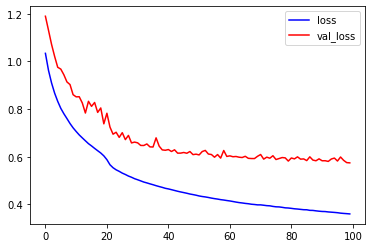

In [70]:
plt.plot(h.history['loss'], 'b-')
plt.plot(h.history['val_loss'], 'r-')
plt.legend(['loss','val_loss'])

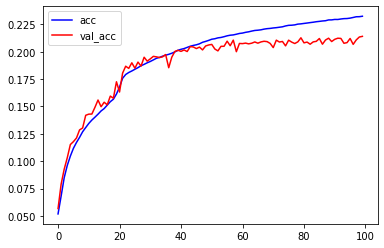

In [71]:
plt.plot(h.history['acc'], 'b-')
plt.plot(h.history['val_acc'], 'r-')
plt.legend(['acc','val_acc'])

### 번역 실행

In [72]:
enc_model = Model(enc_input, enc_states)

In [73]:
dec_input_h = Input(shape=(256,))
dec_input_c = Input(shape=(256,))
dec_states_input = [dec_input_h, dec_input_c]

In [74]:
dec_outputs, dec_h, dec_c = dec_lstm(dec_input, initial_state=dec_states_input)
dec_states = [dec_h, dec_c]

dec_outputs2 = dec_dense(dec_outputs)

dec_model = Model([dec_input] + dec_states_input, [dec_outputs2] + dec_states)

### 출력 테스트

In [75]:
def decode_sequence(seq):
    states_value = enc_model.predict(seq)
    
    output_seq = np.zeros([1,1,94]) # 94 는 불어사전 문자수
    output_seq[0,0,output_chars.index('\t')] = 1 # 첫번째 입력문자를 '\t' 로 설정
    
    stop = False
    result = ''
    
    while not stop:
        output_tokens, h, c = dec_model.predict([output_seq] + states_value)
        result += output_chars[np.argmax(output_tokens[0,-1,:])]
        
        if (result[-1]=='\n' or len(result)>=59): # 59는 불어 문장 최대 길이
            stop = True
            
        output_seq = np.zeros([1,1,94]) # 94 는 불어사전 문자수
        output_seq[0,0,np.argmax(output_tokens[0,-1])] = 1
        states_value = [h,c]
        
    return result

In [76]:
for i in range(2):
    seq = enc_in_data[5000+i:5000+i+1]
    result = decode_sequence(seq)
    
    print('################################')
    print(input_texts[5000+i])
    print('=>')
    print(result)

################################
I hate flying.
=>
Je déteste le chante.

################################
I hate losing.
=>
Je déteste le chante.



In [77]:
start = 7000
for i in range(3):
    seq = enc_in_data[start+i:start+i+1]
    result = decode_sequence(seq)
    
    print('################################')
    print(input_texts[start+i])
    print(output_texts[start+i][1:-1])
    print('=>')
    #print('[%s]' % result.replace(' ','_'))
    print('[%s]' % result)

################################
He's too drunk.
Il est trop ivre.
=>
[Il est trop contente.
]
################################
He's very open.
Il est très ouvert.
=>
[Il est trap contrais !
]
################################
Hello everyone!
Salut tout le monde !
=>
[Salut teu de la mais !
]


### 새로운 문장으로 테스트

In [83]:
#s1, s2 = lines[10010].strip().split('\t')
s1 = 'I want to go home.'
s2 = ''
v = [input_chars.index(c) for c in s1]

a = np.zeros([1,30,71])
for i in range(len(v)):
    a[0,i,v[i]] = 1
    
r = decode_sequence(a)
display(s1, s2, r[:-1])

'I want to go home.'

''

'Je ve tendisse.'